## Kaggle Competition: Personalized Medicine - Redefining Cancer Treatment
### _Predict the effect of Genetic Variants to enable Personalized Medicine_
#### Competition website: https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview
#### Competition description (from website):
##### Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC (Memorial Sloan Kettering Cancer Center) is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.
#### Competition evaluation (from website):
##### Submissions are evaluated on Multi Class Log Loss between the predicted probability (of 9 different classes of genetic variations) and the observed target.
#### Models' public test-set evaluation:
##### Recall rate (multi-class weighted avg.), per standard medical statistical metrics. Recall formula: tp/(tp+fn).

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import gc
import re

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.classification import log_loss

from IPython.display import Markdown as md

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize.casual import casual_tokenize

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import casual_tokenize

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn import preprocessing

from collections import Counter
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE, SMOTENC
from sklearn.model_selection import PredefinedSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from mlxtend.plotting import plot_confusion_matrix

import pickle

In [3]:
# read in full training data
training_variants=pd.read_csv('training_variants')
training_text=pd.read_csv('training_text',sep='\|\|',engine='python',skiprows=1,names=['ID','Text'])

In [4]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
training_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
sample_submission=pd.read_csv('stage2_sample_submission.csv')

In [7]:
sample_submission.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0


In [8]:
classes=sample_submission.shape[1]-1
print(classes)

9


### Create random classification to establish baseline max. MULTICLASS LOG-LOSS metric

In [9]:
#test code for creating array of probabilities that add up to 1.0
a=np.random.rand(9)
print(a)
a=a/a.sum()
print(a)
b=a.sum()
print(b)
if b>1.0:
    a[0]=a[0]-(b-1.0) #correct for numerical error in sum
print(a.sum())

[0.92900503 0.3439297  0.28272476 0.71890399 0.97834482 0.50187139
 0.94480477 0.64170296 0.18301467]
[0.16816695 0.06225758 0.05117837 0.13013481 0.17709836 0.09084793
 0.17102699 0.11616001 0.03312901]
1.0000000000000002
0.9999999999999999


In [10]:
random_classification_probabilities=np.zeros((training_variants.shape[0],classes))
random_classification_probabilities.shape

(3321, 9)

In [11]:
for i in range(random_classification_probabilities.shape[0]):
    a=np.random.rand(classes)
    a=a/a.sum()
    b=a.sum()
    if b>1.0:
        a[0]=a[0]-(b-1.0) #correct for numerical error in sum
    random_classification_probabilities[i]=a
random_classification_probabilities.shape

(3321, 9)

In [12]:
random_classification_probabilities[:5,:]

array([[0.22227066, 0.03658468, 0.04169838, 0.07395859, 0.22009018,
        0.09931268, 0.08902815, 0.10557164, 0.11148504],
       [0.14028814, 0.17140325, 0.02632469, 0.08189315, 0.13049298,
        0.11848135, 0.03391748, 0.1950861 , 0.10211287],
       [0.00343905, 0.21562468, 0.12394347, 0.10576132, 0.11048919,
        0.11681084, 0.02971833, 0.10806029, 0.18615283],
       [0.15368713, 0.1275252 , 0.00690986, 0.13960018, 0.1309518 ,
        0.12595042, 0.12609266, 0.10785721, 0.08142554],
       [0.05151328, 0.0756105 , 0.09373433, 0.17157144, 0.09894813,
        0.15607979, 0.15971364, 0.18151897, 0.01130992]])

In [13]:
y_true=training_variants.Class.values #convert Series to array
y_true

array([1, 2, 2, ..., 1, 4, 4], dtype=int64)

In [14]:
random_multiclass_log_loss=log_loss(y_true,random_classification_probabilities,labels=[1,2,3,4,5,6,7,8,9])

In [15]:
md(">Baseline worst-case (random) multi-class log-loss: {}".format(round(random_multiclass_log_loss,6)))

>Baseline worst-case (random) multi-class log-loss: 2.470482

In [16]:
#merge both training dataframes
training_full=training_variants.merge(training_text, on='ID', how='inner')

In [17]:
training_full.tail()

,ID,Gene,Variation,Class,Text
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,RUNX1,K83E,4,The most frequent mutations associated with le...


In [18]:
training_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [19]:
#review missing values for 'Text'
training_full[training_full['Text'].isnull()==True]
indices_of_missing_Text=training_full[training_full['Text'].isnull()==True].index
training_full.iloc[indices_of_missing_Text]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [20]:
#impute missing value for 'Text', by combining its corresponding 'Gene', 'Variation' features (separated by one white space)
training_full.Text.fillna((training_full.Gene+' '+training_full.Variation),inplace=True)
training_full.iloc[indices_of_missing_Text]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


In [21]:
training_full.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [22]:
pd.value_counts(training_full.Gene).sum()

3321

In [23]:
pd.value_counts(training_full.Variation).sum()

3321

In [24]:
#remove leading and trailing spaces and lower-case 'Gene' feature
training_full['Gene']=training_full['Gene'].apply(lambda x: x.strip())
training_full['Gene']=training_full['Gene'].apply(lambda x: x.lower())

In [25]:
pd.value_counts(training_full.Gene)

brca1    264
tp53     163
egfr     141
pten     126
brca2    125
        ... 
hla-b      1
foxo1      1
fancc      1
flt1       1
fgf3       1
Name: Gene, Length: 264, dtype: int64

In [26]:
pd.value_counts(training_full.Variation)

Truncating Mutations     93
Deletion                 74
Amplification            71
Fusions                  34
Overexpression            6
                         ..
Y1045*                    1
H773L                     1
Q635E                     1
E565G                     1
SEC16A1-NOTCH1 Fusion     1
Name: Variation, Length: 2996, dtype: int64

In [27]:
# upon inspection, 'Variation' and 'Text' features will be cleaned-up in a similar way

In [28]:
# text preprocessor cleanup code

def text_preprocessor_tokenizer(text):
    # remove leading & trailing white spaces
    text=text.strip()
    
    # remove all HTML markup
    text = re.sub('<[^>]*>', '', text)
    
    # find and store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

    # remove non-word characters
    # convert text to lower-case
    # also want to replace '_' with ' ', per inspections of 'Variation' & 'Text' features
    # add back emoticons at the end of string, remove "nose"='-' of emoticons
    text = re.sub('[\W]+', ' ', text.lower()).replace('_',' ') + ' '.join(emoticons).replace('-', '')
    
    # correction for if emoticon is first/last term
    text = text.strip()
    
    return text

In [29]:
# test text_preprocessor_tokenizer function
text_preprocessor_tokenizer(" ;) </a>This ;) is :( a test :-)! 123 XyZ AbC123* dEf4-5GhI6 789_JkL0 ;) ")
#text_preprocessor_tokenizer(" </a>This is a test! 123 XyZ AbC123* dEf4-5GhI6 789_JkL0 ")

'this is a test 123 xyz abc123 def4 5ghi6 789 jkl0 ;) ;) :( :) ;)'

In [30]:
# clean text data on BOTH 'Variation' and 'Text' features, before any train/test splitting
training_full['Variation'] = training_full['Variation'].apply(text_preprocessor_tokenizer)
training_full['Text'] = training_full['Text'].apply(text_preprocessor_tokenizer)

In [31]:
training_full.head()

,ID,Gene,Variation,Class,Text
0,0,fam58a,truncating mutations,1,cyclin dependent kinases cdks regulate a varie...
1,1,cbl,w802,2,abstract background non small cell lung cancer...
2,2,cbl,q249e,2,abstract background non small cell lung cancer...
3,3,cbl,n454d,3,recent evidence has demonstrated that acquired...
4,4,cbl,l399v,4,oncogenic mutations in the monomeric casitas b...


In [32]:
pd.value_counts(training_full.Class)

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

Text(0.5, 1.0, 'Class counts in full training data')

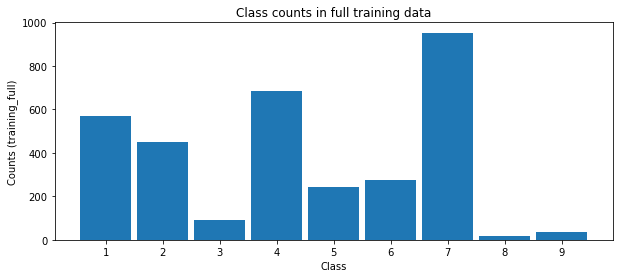

In [33]:
plt.figure(figsize=(10,4))
unique_classes, classes_array = np.unique(training_full['Class'],return_inverse=True)
counts = np.bincount(classes_array)
plt.bar(unique_classes,counts,width=0.9)
plt.xticks(unique_classes)
plt.xlabel('Class')
plt.ylabel('Counts (training_full)')
plt.title('Class counts in full training data')

#### Comment: This shows an IMBALANCED training set, which we will attempt to be addressed via 'over-sampling' technique - 'under-sampling' is not an option in this case, since the training dataset is too small (<~10K).

In [34]:
# perform the main train-test splits

# create X,y, not including 'Variation','Text'
y=training_full.Class
X=training_full.drop(columns=['Class'])

# 70%/30% train-test split
# no need for separate 50/50 val-test split after this, will use K-fold cross-val
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)

#reset indices starting from 0, since 'ID' column no longer matches index
X_train_df=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
X_test_df=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

print('X_train_df shape: {0}'.format(X_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

print('X_test_df shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))

X_train_df shape: (2324, 4)
y_train shape: (2324,)
X_test_df shape: (997, 4)
y_test shape: (997,)


In [35]:
print(y_train.head())
X_train_df.head()

0    6
1    1
2    1
3    1
4    4
Name: Class, dtype: int64


,ID,Gene,Variation,Text
0,2884,brca2,h2074n,mutation screening of the breast and ovarian c...
1,414,tp53,h214r,mutations of the sequence specific master regu...
2,1080,arid1a,truncating mutations,arid1a baf250a promotes the formation of swi s...
3,1844,igf1r,g1125a,background igf i receptor igf1r plays an essen...
4,2211,pten,a126d,the pten phosphatase and tensin homolog phosph...


In [36]:
print(y_test.head())
X_test_df.head()

0    1
1    6
2    7
3    6
4    7
Name: Class, dtype: int64


,ID,Gene,Variation,Text
0,1828,ppp2r1a,s256w,a recent genome wide sequencing analysis of al...
1,2451,brca1,y179c,abstract the brca1 tumor suppressor gene is fo...
2,786,erbb4,e563k,tyrosine phosphorylation is important in signa...
3,3131,kras,r164q,hotspot mutations of ras drive cell transforma...
4,281,nkx2-1,amplification,we used high resolution array analysis to disc...


#### Before proceeding with the processing (one-hot'ing) of the categorical features ('Gene', 'Variation'), will want to first process the 'Text' feature - this is in order to address the train data IMBALANCE via Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC), where the RAW 'Gene' and 'Variation' columns will be used categorical features.

### Processing 'Text': TfidfVectorizer (w/out stemming)

In [37]:
# porter=PorterStemmer()
# def porter_stem(text):
#     return ' '.join(porter.stem(word) for word in text.split())

In [38]:
# X_train_Text_stem=X_train_df['Text'].apply(lambda x: porter_stem(x))
# X_test_Text_stem =X_test_df['Text'].apply(lambda x: porter_stem(x))
train_Text=X_train_df['Text']
test_Text=X_test_df['Text']

##### TF-IDF parameters were arrived at from prior knowledge, as well as quick trial-n-error:

In [39]:
tfidf=TfidfVectorizer(ngram_range=(1,1),max_df=0.50,min_df=7,max_features=1000,norm='l2',use_idf=True,smooth_idf=True)

tfidf=tfidf.fit(train_Text)

train_Text_tfidf=tfidf.transform(train_Text)
test_Text_tfidf=tfidf.transform(test_Text)

print("train_Text_tfidf shape:",train_Text_tfidf.shape)
print("train_Text_tfidf type:",type(train_Text_tfidf))
print("test_Text_tfidf shape:",test_Text_tfidf.shape)
print("test_Text_tfidf type:",type(test_Text_tfidf))

train_Text_tfidf shape: (2324, 1000)
train_Text_tfidf type: <class 'scipy.sparse.csr.csr_matrix'>
test_Text_tfidf shape: (997, 1000)
test_Text_tfidf type: <class 'scipy.sparse.csr.csr_matrix'>


In [40]:
# create dataframes of 'Text' (tfidf) feature only
train_Text_tfidf_df=pd.DataFrame(train_Text_tfidf.todense(),columns=tfidf.get_feature_names())
test_Text_tfidf_df=pd.DataFrame(test_Text_tfidf.todense(),columns=tfidf.get_feature_names())

In [41]:
train_Text_tfidf_df

,01,05,150,1994,1995,1996,1997,1998,1999,1c,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.008708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.011158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.003786,0.003153,0.099213,0.012839,0.006238,0.000000,0.009486,0.011742,0.000000,0.0
2,0.000000,0.007601,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013489,...,0.000000,0.000000,0.009594,0.037246,0.007239,0.000000,0.014677,0.009084,0.000000,0.0
3,0.035554,0.062619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.018095,0.000000,0.000000,0.245455,0.134175,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.002432,...,0.000000,0.000000,0.110695,0.005372,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,0.004445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.006947,...,0.009050,0.026384,0.000000,0.003836,0.000000,0.000000,0.007559,0.014034,0.020432,0.0
2320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017884,...,0.069897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2321,0.000000,0.000000,0.020484,0.000000,0.007117,0.000000,0.000000,0.0,0.0,0.004358,...,0.005677,0.000000,0.000000,0.000000,0.130973,0.306876,0.000000,0.005869,0.000000,0.0
2322,0.006530,0.005750,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.005635,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [42]:
test_Text_tfidf_df

,01,05,150,1994,1995,1996,1997,1998,1999,1c,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0.000000,0.000000,0.001485,0.017500,0.014446,0.003932,0.009167,0.012824,0.024925,0.002527,...,0.000000,0.001371,0.000000,0.011166,0.033909,0.004045,0.000000,0.000000,0.001487,0.00000
1,0.015395,0.010168,0.000000,0.009254,0.014732,0.000000,0.034903,0.021798,0.008473,0.003007,...,0.000000,0.019578,0.209607,0.000000,0.000000,0.000000,0.013088,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.011907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.005596,0.005438,0.008108,0.011026,0.040942,0.011921,0.00000
3,0.002065,0.001818,0.000000,0.004965,0.002635,0.000000,0.004681,0.000000,0.000000,0.016132,...,0.000000,0.003501,0.000000,0.001782,0.008658,0.000000,0.015798,0.017382,0.009489,0.00000
4,0.004516,0.003977,0.000000,0.005430,0.005762,0.016470,0.005119,0.005116,0.014914,0.007057,...,0.000000,0.000000,0.000000,0.000000,0.007575,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.000000,0.003087,0.003219,0.000000,0.000000,0.000000,0.003974,0.019857,0.007719,0.005479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020864,0.003689,0.003223,0.00000
993,0.004024,0.007087,0.007388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020479,0.020469,0.000000,0.013889,0.000000,0.000000,0.000000,0.021171,0.011096,0.00000
994,0.000000,0.000973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000863,...,0.000000,0.002811,0.000000,0.001907,0.000000,0.000000,0.000000,0.002326,0.000000,0.09895
995,0.000000,0.039628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009565,0.000000,0.000000,0.00000


In [43]:
#concat X's with rest of the X_train/test dataframes
X_train_Text_tfidf_df=pd.concat([X_train_df,train_Text_tfidf_df],axis=1).drop(columns=['Text'])
X_test_Text_tfidf_df=pd.concat([X_test_df,test_Text_tfidf_df],axis=1).drop(columns=['Text'])

In [44]:
print(y_train.head())
X_train_Text_tfidf_df.head()

0    6
1    1
2    1
3    1
4    4
Name: Class, dtype: int64


,ID,Gene,Variation,01,05,150,1994,1995,1996,1997,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,2884,brca2,h2074n,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.008708,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,414,tp53,h214r,0.011158,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.003786,0.003153,0.099213,0.012839,0.006238,0.0,0.009486,0.011742,0.0,0.0
2,1080,arid1a,truncating mutations,0.000000,0.007601,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.009594,0.037246,0.007239,0.0,0.014677,0.009084,0.0,0.0
3,1844,igf1r,g1125a,0.035554,0.062619,0.0,0.0,0.0,0.0,0.0,...,0.018095,0.000000,0.000000,0.245455,0.134175,0.0,0.000000,0.000000,0.0,0.0
4,2211,pten,a126d,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.110695,0.005372,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [45]:
print(y_test.head())
X_test_Text_tfidf_df.head()

0    1
1    6
2    7
3    6
4    7
Name: Class, dtype: int64


,ID,Gene,Variation,01,05,150,1994,1995,1996,1997,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,1828,ppp2r1a,s256w,0.000000,0.000000,0.001485,0.017500,0.014446,0.003932,0.009167,...,0.0,0.001371,0.000000,0.011166,0.033909,0.004045,0.000000,0.000000,0.001487,0.0
1,2451,brca1,y179c,0.015395,0.010168,0.000000,0.009254,0.014732,0.000000,0.034903,...,0.0,0.019578,0.209607,0.000000,0.000000,0.000000,0.013088,0.000000,0.000000,0.0
2,786,erbb4,e563k,0.000000,0.000000,0.011907,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.005596,0.005438,0.008108,0.011026,0.040942,0.011921,0.0
3,3131,kras,r164q,0.002065,0.001818,0.000000,0.004965,0.002635,0.000000,0.004681,...,0.0,0.003501,0.000000,0.001782,0.008658,0.000000,0.015798,0.017382,0.009489,0.0
4,281,nkx2-1,amplification,0.004516,0.003977,0.000000,0.005430,0.005762,0.016470,0.005119,...,0.0,0.000000,0.000000,0.000000,0.007575,0.000000,0.000000,0.000000,0.000000,0.0


#### Verify this TF-IDF strategy is appropriate by performing Naive-Bayes classification using only the 'Text' feature:

In [46]:
clf = MultinomialNB()
clf.fit(X_train_Text_tfidf_df.drop(columns=['ID','Gene','Variation']),y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
# Evaluate multiclass_log_loss
clf_predict_proba=clf.predict_proba(X_test_Text_tfidf_df.drop(columns=['ID','Gene','Variation']))
clf_multiclass_log_loss=log_loss(y_test,clf_predict_proba,labels=[1,2,3,4,5,6,7,8,9])
print('MultinomialNB multiclass_log_loss:',round(clf_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.281662


#### Comment: Thus, YES, this TF-IDF strategy performs significantly better, on a multiclass-log-loss, than the random guessing benchmark (see above)

#### Will now address the observed TRAIN data IMBALANCE by over-sampling (since the dataset is too small, <~10K, to use under-sampling technique)

In [48]:
print("Original  training target classes:",sorted(Counter(y_train).items()))

X_train_Text_tfidf_drop_ID_df=X_train_Text_tfidf_df.drop(columns=['ID']).copy()

cat_features_indices=[]
cat_features_indices.append(X_train_Text_tfidf_drop_ID_df.columns.get_loc('Gene'))
cat_features_indices.append(X_train_Text_tfidf_drop_ID_df.columns.get_loc('Variation'))
cat_features_indices=np.array(cat_features_indices)

X_train_Text_tfidf_drop_ID_resample,y_train_resample=SMOTENC(categorical_features=cat_features_indices,random_state=42,n_jobs=-1).fit_resample(X_train_Text_tfidf_drop_ID_df,y_train)

print("Resampled training target classes:",sorted(Counter(y_train_resample).items()))

X_train_Text_tfidf_drop_ID_resample_df=pd.DataFrame(X_train_Text_tfidf_drop_ID_resample,columns=X_train_Text_tfidf_drop_ID_df.columns)
y_train_resample=pd.Series(y_train_resample) 

print("X_train_Text_tfidf_drop_ID_df shape_df:", X_train_Text_tfidf_drop_ID_df.shape)
print("X_train_Text_tfidf_drop_ID_resample_df shape:", X_train_Text_tfidf_drop_ID_resample_df.shape)

Original  training target classes: [(1, 398), (2, 316), (3, 62), (4, 480), (5, 169), (6, 193), (7, 667), (8, 13), (9, 26)]
Resampled training target classes: [(1, 667), (2, 667), (3, 667), (4, 667), (5, 667), (6, 667), (7, 667), (8, 667), (9, 667)]
X_train_Text_tfidf_drop_ID_df shape_df: (2324, 1002)
X_train_Text_tfidf_drop_ID_resample_df shape: (6003, 1002)


In [49]:
# Drop (unenessary) ID column for the test set as well, for consistency
X_test_Text_tfidf_drop_ID_df=X_test_Text_tfidf_df.drop(columns=['ID']).copy()

In [50]:
print(y_train_resample)
X_train_Text_tfidf_drop_ID_resample_df

0       6
1       1
2       1
3       1
4       4
       ..
5998    9
5999    9
6000    9
6001    9
6002    9
Length: 6003, dtype: int64


,Gene,Variation,01,05,150,1994,1995,1996,1997,1998,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,brca2,h2074n,0,0,0,0,0,0,0,0,...,0,0,0.00870844,0,0,0,0,0,0,0
1,tp53,h214r,0.0111579,0,0,0,0,0,0,0,...,0.00378588,0.00315337,0.0992131,0.0128386,0.00623825,0,0.00948611,0.0117417,0,0
2,arid1a,truncating mutations,0,0.00760146,0,0,0,0,0,0,...,0,0,0.00959416,0.0372456,0.00723905,0,0.0146773,0.00908358,0,0
3,igf1r,g1125a,0.0355537,0.0626185,0,0,0,0,0,0,...,0.0180951,0,0,0.245455,0.134175,0,0,0,0,0
4,pten,a126d,0,0,0,0,0,0,0,0,...,0,0,0.110695,0.00537163,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,sf3b1,k666m,0.0109007,0,0,0,0,0,0,0,...,0,0,0,0.065849,0,0.0136306,0.0185349,0,0.01002,0
5999,ezh2,y646f,0.00824478,0.012748,0.00189869,0.00248633,0,0,0,0,...,0,0.00526007,0,0.00892323,0.215055,0.00258592,0.0105491,0.0152336,0.026588,0
6000,ezh2,y646n,0.00646937,0.0113941,0.00593964,0,0.00825477,0,0,0.00732814,...,0,0,0,0.0669946,0.00542544,0,0,0.00680786,0,0
6001,ezh2,y646n,0.00646937,0.0113941,0.00593964,0,0.00825477,0,0,0.00732814,...,0,0,0,0.0669946,0.00542544,0,0,0.00680786,0,0


#### Note: the additional systhesized samples are placed starting at the bottom row of the train data array

In [51]:
print(y_test)
X_test_Text_tfidf_drop_ID_df

0      1
1      6
2      7
3      6
4      7
      ..
992    4
993    2
994    1
995    5
996    5
Name: Class, Length: 997, dtype: int64


,Gene,Variation,01,05,150,1994,1995,1996,1997,1998,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,ppp2r1a,s256w,0.000000,0.000000,0.001485,0.017500,0.014446,0.003932,0.009167,0.012824,...,0.000000,0.001371,0.000000,0.011166,0.033909,0.004045,0.000000,0.000000,0.001487,0.00000
1,brca1,y179c,0.015395,0.010168,0.000000,0.009254,0.014732,0.000000,0.034903,0.021798,...,0.000000,0.019578,0.209607,0.000000,0.000000,0.000000,0.013088,0.000000,0.000000,0.00000
2,erbb4,e563k,0.000000,0.000000,0.011907,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.005596,0.005438,0.008108,0.011026,0.040942,0.011921,0.00000
3,kras,r164q,0.002065,0.001818,0.000000,0.004965,0.002635,0.000000,0.004681,0.000000,...,0.000000,0.003501,0.000000,0.001782,0.008658,0.000000,0.015798,0.017382,0.009489,0.00000
4,nkx2-1,amplification,0.004516,0.003977,0.000000,0.005430,0.005762,0.016470,0.005119,0.005116,...,0.000000,0.000000,0.000000,0.000000,0.007575,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,tsc2,v705e,0.000000,0.003087,0.003219,0.000000,0.000000,0.000000,0.003974,0.019857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020864,0.003689,0.003223,0.00000
993,kit,v559c,0.004024,0.007087,0.007388,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020479,0.020469,0.000000,0.013889,0.000000,0.000000,0.000000,0.021171,0.011096,0.00000
994,cbl,deletion,0.000000,0.000973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002811,0.000000,0.001907,0.000000,0.000000,0.000000,0.002326,0.000000,0.09895
995,pik3ca,a1020v,0.000000,0.039628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009565,0.000000,0.000000,0.00000


#### Process the 'Gene' and 'Variation' features

In [52]:
# one-hot encode 'Gene', 'Variation' - will keep ALL one-hot columns, since NOT using linear regression models (but rather just TREES) 

cat_features=['Gene','Variation']

onehotenc=OneHotEncoder(handle_unknown='ignore',sparse=False)

onehotenc.fit(X_train_Text_tfidf_drop_ID_resample_df[cat_features].values.reshape(-1,len(cat_features)))

train_1hot_cols_resample=onehotenc.transform(X_train_Text_tfidf_drop_ID_resample_df[cat_features].values.reshape(-1,len(cat_features)))
test_1hot_cols=onehotenc.transform(X_test_Text_tfidf_drop_ID_df[cat_features].values.reshape(-1,len(cat_features)))

print('train_1hot_cols_resample is of type: ', type(train_1hot_cols_resample))
print('train_1hot_cols_resample is of shape: ', train_1hot_cols_resample.shape)
print('test_1hot_cols is of type: ', type(test_1hot_cols))
print('test_1hot_cols is of shape: ', test_1hot_cols.shape)

train_1hot_cols_resample is of type:  <class 'numpy.ndarray'>
train_1hot_cols_resample is of shape:  (6003, 2339)
test_1hot_cols is of type:  <class 'numpy.ndarray'>
test_1hot_cols is of shape:  (997, 2339)


In [53]:
# create dataframes with only the one-hot columns
train_1hot_cols_resample_df=pd.DataFrame(train_1hot_cols_resample.astype(int))
test_1hot_cols_df=pd.DataFrame(test_1hot_cols.astype(int))

print('train_1hot_cols_resample_df is of type: ', type(train_1hot_cols_resample_df))
print('train_1hot_cols_resample_df is of shape: ', train_1hot_cols_resample_df.shape)
print('test_1hot_cols_df is of type: ', type(test_1hot_cols_df))
print('test_1hot_cols_df is of shape: ', test_1hot_cols_df.shape)

train_1hot_cols_resample_df is of type:  <class 'pandas.core.frame.DataFrame'>
train_1hot_cols_resample_df is of shape:  (6003, 2339)
test_1hot_cols_df is of type:  <class 'pandas.core.frame.DataFrame'>
test_1hot_cols_df is of shape:  (997, 2339)


In [54]:
#rename dataframes' one-hot columns
train_1hot_cols_resample_df.columns=onehotenc.get_feature_names()
test_1hot_cols_df.columns=onehotenc.get_feature_names()

In [55]:
#concat X's with one-hot columns, and drop original non-one-hot columns
X_train_1hot_cols_Text_tfidf_drop_ID_resample_df=pd.concat([train_1hot_cols_resample_df,X_train_Text_tfidf_drop_ID_resample_df],axis=1).drop(columns=['Gene','Variation'])
X_test_1hot_cols_Text_tfidf_drop_ID_df=pd.concat([test_1hot_cols_df,X_test_Text_tfidf_drop_ID_df],axis=1).drop(columns=['Gene','Variation'])

In [56]:
print(y_train_resample)
X_train_1hot_cols_Text_tfidf_drop_ID_resample_df

0       6
1       1
2       1
3       1
4       4
       ..
5998    9
5999    9
6000    9
6001    9
6002    9
Length: 6003, dtype: int64


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.00870844,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.00378588,0.00315337,0.0992131,0.0128386,0.00623825,0,0.00948611,0.0117417,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0.00959416,0.0372456,0.00723905,0,0.0146773,0.00908358,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0180951,0,0,0.245455,0.134175,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.110695,0.00537163,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.065849,0,0.0136306,0.0185349,0,0.01002,0
5999,0,0,0,0,0,0,0,0,0,0,...,0,0.00526007,0,0.00892323,0.215055,0.00258592,0.0105491,0.0152336,0.026588,0
6000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0669946,0.00542544,0,0,0.00680786,0,0
6001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0669946,0.00542544,0,0,0.00680786,0,0


In [57]:
print(y_test)
X_test_1hot_cols_Text_tfidf_drop_ID_df

0      1
1      6
2      7
3      6
4      7
      ..
992    4
993    2
994    1
995    5
996    5
Name: Class, Length: 997, dtype: int64


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.001371,0.000000,0.011166,0.033909,0.004045,0.000000,0.000000,0.001487,0.00000
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.019578,0.209607,0.000000,0.000000,0.000000,0.013088,0.000000,0.000000,0.00000
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.005596,0.005438,0.008108,0.011026,0.040942,0.011921,0.00000
3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.003501,0.000000,0.001782,0.008658,0.000000,0.015798,0.017382,0.009489,0.00000
4,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.007575,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020864,0.003689,0.003223,0.00000
993,0,0,0,0,0,0,0,0,0,0,...,0.020479,0.020469,0.000000,0.013889,0.000000,0.000000,0.000000,0.021171,0.011096,0.00000
994,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.002811,0.000000,0.001907,0.000000,0.000000,0.000000,0.002326,0.000000,0.09895
995,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009565,0.000000,0.000000,0.00000


#### TF-IDF 'Text' features weights are, by design, several orders of magnitude smaller than simple one-hot encoding applied to 'Gene', 'Variation' features - would normally re-scale the data, but since planning to used TREES (via XGBoost) as the classifier, then there is NO NEED TO RE-SCALE the features data.

In [58]:
# scaler = preprocessing.StandardScaler().fit(X_train_1hot_cols_Text_tfidf_drop_ID_resample_df)

# X_train_1hot_cols_Text_tfidf_drop_ID_resample_scale=scaler.transform(X_train_1hot_cols_Text_tfidf_drop_ID_resample_df)
# X_test_1hot_cols_Text_tfidf_drop_ID_scale=scaler.transform(X_test_1hot_cols_Text_tfidf_drop_ID_df)

In [59]:
# create final train/test data sets
X_train_final_df=X_train_1hot_cols_Text_tfidf_drop_ID_resample_df.copy()
X_test_final_df=X_test_1hot_cols_Text_tfidf_drop_ID_df.copy()
y_train_final=y_train_resample.copy()
y_test_final=y_test.copy()

#### Before proceeding to GridSearchCV of model parameters, need to pre-define the valid CV samples, so that the synthesized samples are NOT used for cross-val, since this would result in a severe overfitting problem.

In [60]:
# Create test-fold array to split the non-resampled X_train set into the three (3) required CV sets (cv=3): [0,1,2]
# The synthesized set will never be used to CV purposes.

cv_sets=3

#resampled_indices=pd.isnull(X_train_1hot_cols_Text_tfidf_drop_ID_resample_df).any(1).to_numpy().nonzero()
resampled_indices=np.array(range(X_train_df.shape[0],X_train_final_df.shape[0]))

# initialize test_fold array to be used in PredefinedSplit
test_fold=np.zeros((X_train_final_df.shape[0],), dtype=int)

cv_range_0=np.array(range(0,X_train_df.shape[0]//cv_sets))
cv_range_1=np.array(range(X_train_df.shape[0]//cv_sets,2*(X_train_df.shape[0]//cv_sets)))
cv_range_2=np.array(range(2*(X_train_df.shape[0]//cv_sets),3*(X_train_df.shape[0]//cv_sets)+X_train_df.shape[0]%cv_sets))

# declare test-fold CV set numbers
test_fold[cv_range_0]=0
test_fold[cv_range_1]=1
test_fold[cv_range_2]=2

# resampled indices do not get used as CV
test_fold[resampled_indices]=-1

print('Double-check the test-fold array edge members:')
print('test_fold[0]:',test_fold[0])
print('test_fold[773]:',test_fold[773])
print('test_fold[774]:',test_fold[774])
print('test_fold[1547]:',test_fold[1547])
print('test_fold[1548]:',test_fold[1548])
print('test_fold[2323]:',test_fold[2323])
print('test_fold[2324]:',test_fold[2324])
print('test_fold[6002]:',test_fold[6002])

Double-check the test-fold array edge members:
test_fold[0]: 0
test_fold[773]: 0
test_fold[774]: 1
test_fold[1547]: 1
test_fold[1548]: 2
test_fold[2323]: 2
test_fold[2324]: -1
test_fold[6002]: -1


## *** MODEL USING RESAMPLED (SMOTE-NC OVERSAMPLED) TRAINING SET ***

### Initial XGBoost GridSearchCV indicated:
#### Best parameters:
#### {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400} 
#### Best score (neg_log_loss):
#### -0.780201482272391
#### Best XGB model-1 multiclass_log_loss, on TEST SET: 1.072509

### Focused XGBoost GridSearchCV indicated:
#### Best parameters:
#### {'learning_rate': 0.085, 'max_depth': 3, 'n_estimators': 400}
#### Best score (neg_log_loss):
#### -0.7793900966283213
#### Best XGB model-1 multiclass_log_loss, on TEST SET: 1.068926

### Model parameters that yield the BEST multiclass_log_loss, on TEST SET = 1.068926
#### {'learning_rate': 0.085, 'max_depth': 3, 'n_estimators': 400}

### WARNING!!! ... TEST SET LOSS >> TRAIN MODEL LOSS, by about +37% - thus severe OVERFITTING, suspect known problems with the use of oversampling strategies

In [61]:
# GridSearchCV for best XGBoost parameters

#cv_splits=3 #standard default
cv_splits=PredefinedSplit(test_fold=test_fold) #if using resampled training set

parameters = {
#     'max_depth': [3,5,7,9],
#     'learning_rate': [0.100,0.070,0.040,0.010],
#     'n_estimators':  [100,400,700,1000],
#     'max_depth': [2,3,4],
#     'learning_rate': [0.115,0.100,0.085],
#     'n_estimators':  [250,400,550],
    'max_depth': [3],
    'learning_rate': [0.085],
    'n_estimators':  [400],
}

# create a base XGB model
xgb_model_1 = XGBClassifier(tree_method='gpu_hist',objective='multi:softprob',random_state=42,verbosity=2)

# instantiate GridSearch model
xgb_grid_search_1 = GridSearchCV(estimator=xgb_model_1,param_grid=parameters,scoring='neg_log_loss',refit=True,
                                 cv=cv_splits,verbose=3) #n_jobs=-1 option removed, being taken care of in API implementation

# fit GridSearch model
xgb_grid_search_1.fit(X_train_final_df.values,y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.085, max_depth=3, n_estimators=400 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.085, max_depth=3, n_estimators=400, score=-0.759, total=  49.3s
[CV] learning_rate=0.085, max_depth=3, n_estimators=400 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s


[CV]  learning_rate=0.085, max_depth=3, n_estimators=400, score=-0.764, total=  49.6s
[CV] learning_rate=0.085, max_depth=3, n_estimators=400 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.085, max_depth=3, n_estimators=400, score=-0.814, total=  49.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ..., -1, -1])),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=2),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate

In [62]:
# review GridSearch results
xgb_grid_search_1_cv_results_df=pd.DataFrame(xgb_grid_search_1.cv_results_)
xgb_grid_search_1_cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,49.157972,0.199311,0.170336,0.003492,0.085,3,400,"{'learning_rate': 0.085, 'max_depth': 3, 'n_es...",-0.759422,-0.764369,-0.814289,-0.77939,0.024792,1


In [63]:
# review GridSearch results (cont'd)
print('Best estimator:\n\n',xgb_grid_search_1.best_estimator_,'\n')
print('Best parameters:\n\n',xgb_grid_search_1.best_params_,'\n')
print('Best score (neg_log_loss):\n\n',xgb_grid_search_1.best_score_)

Best estimator:

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.085, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2) 

Best parameters:

 {'learning_rate': 0.085, 'max_depth': 3, 'n_estimators': 400} 

Best score (neg_log_loss):

 -0.7793900966283213


In [64]:
# train on best model parameters
best_xgb_model_1=xgb_grid_search_1.best_estimator_
best_xgb_model_1.fit(X_train_final_df.values,y_train_final,
                     early_stopping_rounds=40,
                     eval_set=[(X_test_final_df.values,y_test_final)],
                     eval_metric=['mlogloss'],
                     verbose=True)

[0]	validation_0-mlogloss:2.12028
Will train until validation_0-mlogloss hasn't improved in 40 rounds.
[1]	validation_0-mlogloss:2.05599
[2]	validation_0-mlogloss:2.00466
[3]	validation_0-mlogloss:1.95382
[4]	validation_0-mlogloss:1.91251
[5]	validation_0-mlogloss:1.86961
[6]	validation_0-mlogloss:1.83269
[7]	validation_0-mlogloss:1.79756
[8]	validation_0-mlogloss:1.76427
[9]	validation_0-mlogloss:1.73389
[10]	validation_0-mlogloss:1.70516
[11]	validation_0-mlogloss:1.67983
[12]	validation_0-mlogloss:1.65343
[13]	validation_0-mlogloss:1.62989
[14]	validation_0-mlogloss:1.6079
[15]	validation_0-mlogloss:1.58812
[16]	validation_0-mlogloss:1.56957
[17]	validation_0-mlogloss:1.55233
[18]	validation_0-mlogloss:1.53611
[19]	validation_0-mlogloss:1.51898
[20]	validation_0-mlogloss:1.50373
[21]	validation_0-mlogloss:1.48792
[22]	validation_0-mlogloss:1.47341
[23]	validation_0-mlogloss:1.46056
[24]	validation_0-mlogloss:1.44658
[25]	validation_0-mlogloss:1.43417
[26]	validation_0-mlogloss:1.421

[230]	validation_0-mlogloss:1.07393
[231]	validation_0-mlogloss:1.07373
[232]	validation_0-mlogloss:1.07314
[233]	validation_0-mlogloss:1.07319
[234]	validation_0-mlogloss:1.07342
[235]	validation_0-mlogloss:1.07284
[236]	validation_0-mlogloss:1.07294
[237]	validation_0-mlogloss:1.07291
[238]	validation_0-mlogloss:1.07258
[239]	validation_0-mlogloss:1.07241
[240]	validation_0-mlogloss:1.07237
[241]	validation_0-mlogloss:1.07229
[242]	validation_0-mlogloss:1.07273
[243]	validation_0-mlogloss:1.07237
[244]	validation_0-mlogloss:1.07199
[245]	validation_0-mlogloss:1.07193
[246]	validation_0-mlogloss:1.07102
[247]	validation_0-mlogloss:1.07086
[248]	validation_0-mlogloss:1.07085
[249]	validation_0-mlogloss:1.07115
[250]	validation_0-mlogloss:1.07103
[251]	validation_0-mlogloss:1.07099
[252]	validation_0-mlogloss:1.07058
[253]	validation_0-mlogloss:1.07044
[254]	validation_0-mlogloss:1.07062
[255]	validation_0-mlogloss:1.07089
[256]	validation_0-mlogloss:1.07073
[257]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.085, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2)

In [146]:
# save the model-1 to disk
filename = 'finalized_XBG_model_1.sav'
pickle.dump(best_xgb_model_1, open(filename, 'wb'))

In [67]:
# Evaluate best XGB model multiclass_log_loss, ON TRAIN SET (never inc. resample members)
best_xgb_model_1_predict_probab_train=best_xgb_model_1.predict_proba(X_train_final_df[:X_train_df.shape[0]].values)

In [68]:
# Generate class target names for report table
target_names = ['class1','class2','class3','class4','class5','class6','class7','class8','class9']

In [69]:
# Evaluate predictions, ON TRAIN SET (never inc. resample members)
y_pred=(np.argmax(best_xgb_model_1_predict_probab_train,axis=1))+1

print('Classification report (train set):\n')
print(classification_report(y_train[:y_train.shape[0]], y_pred, target_names=target_names))

Classification report (train set):

              precision    recall  f1-score   support

      class1       0.89      0.83      0.86       398
      class2       0.93      0.90      0.91       316
      class3       0.55      0.84      0.67        62
      class4       0.93      0.91      0.92       480
      class5       0.70      0.75      0.72       169
      class6       0.87      0.93      0.90       193
      class7       0.93      0.91      0.92       667
      class8       1.00      0.92      0.96        13
      class9       0.96      0.96      0.96        26

    accuracy                           0.89      2324
   macro avg       0.86      0.88      0.87      2324
weighted avg       0.89      0.89      0.89      2324



Confusion matrix (train set):


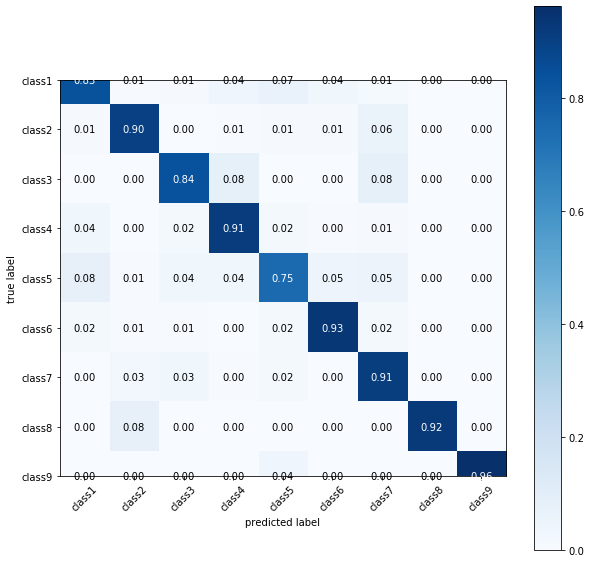

In [114]:
print('Confusion matrix (train set):')
cm=confusion_matrix(y_train[:y_train.shape[0]],y_pred)
#print('Confusion matrix (train set):\n\n',cm)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize=(10, 10),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=target_names,
                               )
plt.show()

In [115]:
# Evaluate best XGB model multiclass_log_loss, on TEST SET
best_xgb_model_1_predict_probab_test=best_xgb_model_1.predict_proba(X_test_final_df.values)
best_xgb_model_1_multiclass_log_loss_test=log_loss(y_test_final,best_xgb_model_1_predict_probab_test,labels=[1,2,3,4,5,6,7,8,9])
print('Best XGB model-1 multiclass_log_loss, on TEST SET:',round(best_xgb_model_1_multiclass_log_loss_test,6))

Best XGB model-1 multiclass_log_loss, on TEST SET: 1.068926


In [116]:
# Evaluate predictions, ON TEST SET
y_pred=(np.argmax(best_xgb_model_1_predict_probab_test,axis=1))+1

print('Classification report (test set):\n')
print(classification_report(y_test_final, y_pred,target_names=target_names))

Classification report (test set):

              precision    recall  f1-score   support

      class1       0.59      0.62      0.61       170
      class2       0.55      0.57      0.56       136
      class3       0.41      0.44      0.43        27
      class4       0.68      0.63      0.65       206
      class5       0.39      0.48      0.43        73
      class6       0.83      0.59      0.69        82
      class7       0.74      0.77      0.76       286
      class8       0.00      0.00      0.00         6
      class9       0.73      0.73      0.73        11

    accuracy                           0.64       997
   macro avg       0.55      0.54      0.54       997
weighted avg       0.64      0.64      0.64       997



C:\Users\dcunz\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix (test set):


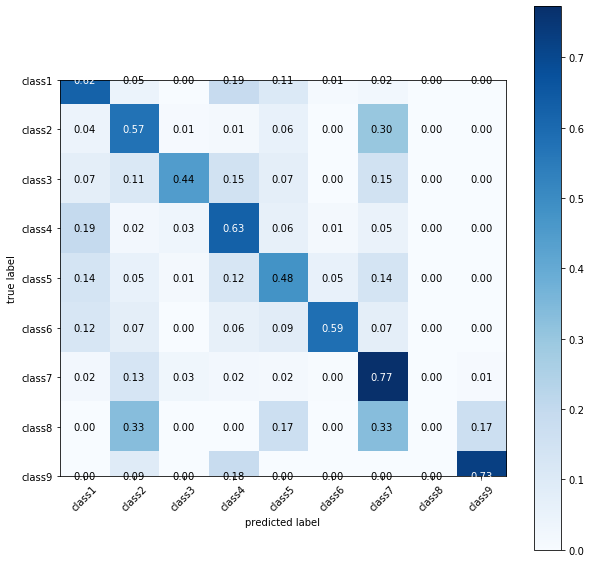

In [118]:
print('Confusion matrix (test set):')
cm=confusion_matrix(y_test_final,y_pred)
#print('Confusion matrix (test set):\n\n',cm)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize=(10, 10),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=target_names,
                               )
plt.show()

#### Comments: Classes 3, 5 show significantly lower recall rates than the other classes; and all scores are significantly lower than train set, indicating that this model-1 (using oversampling to correct data imbalance) DOES NOT GENERALIZE well, and overfits the train set.

### Load competition data

In [119]:
# read in full test data
test_variants=pd.read_csv('stage2_test_variants.csv')
test_text=pd.read_csv('stage2_test_text.csv',sep='\|\|',engine='python',skiprows=1,names=['ID','Text'])

# merge both test dataframes
testing_full=test_variants.merge(test_text, on='ID', how='inner')

#remove leading and trailing spaces and lower-case 'Gene'
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.strip())
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.lower())

# clean text data on 'Variation'
testing_full['Variation'] = testing_full['Variation'].apply(text_preprocessor_tokenizer)
testing_full['Text'] = testing_full['Text'].apply(text_preprocessor_tokenizer)

### Evaluate competition test data

In [120]:
# create X_eval
X_eval_df=testing_full.copy()

# features to TF-IDF
cat_features_tfidf=['Text']

# TF-IDF
eval_Text=X_eval_df['Text']
eval_Text_tfidf=tfidf.transform(eval_Text)

# create dataframe of 'Text' (tfidf) feature only
eval_Text_tfidf_df=pd.DataFrame(eval_Text_tfidf.todense(),columns=tfidf.get_feature_names())
#concat with rest of the X_eval
X_eval_Text_tfidf_df=pd.concat([X_eval_df,eval_Text_tfidf_df],axis=1).drop(columns=['Text'])
# Drop (unenessary) ID column
X_eval_Text_tfidf_drop_ID_df=X_eval_Text_tfidf_df.drop(columns=['ID']).copy()

# one-hot encode 'Gene','Variation' - keeping all one-hot columns, since not using linear regression models (but rather just trees) 
eval_1hot_cols=onehotenc.transform(X_eval_Text_tfidf_drop_ID_df[cat_features].values.reshape(-1,len(cat_features)))
eval_1hot_cols_df=pd.DataFrame(eval_1hot_cols.astype(int))

# rename one-hot columns
eval_1hot_cols_df.columns=onehotenc.get_feature_names()

#concat with rest of the X_eval
X_eval_1hot_cols_Text_tfidf_drop_ID_df=pd.concat([eval_1hot_cols_df,X_eval_Text_tfidf_drop_ID_df],axis=1).drop(columns=['Gene','Variation'])

# standardize all non-ID columns - NOT NECESSARY for tree models
# X_eval_1hot_cols_Text_tfidf_drop_ID_scale=scaler.transform(X_eval_1hot_cols_Text_tfidf_drop_ID_df)

# create final eval data sets
X_eval_final_df=X_eval_1hot_cols_Text_tfidf_drop_ID_df.copy()

print("X_eval_final_df shape:", X_eval_final_df.shape)
X_eval_final_df

X_eval_final_df shape: (986, 3339)


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0,0,0,0,0,0,0,0,0,0,...,0.038223,0.071634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.010741,0.000000,0.003644,0.226655,0.000000,0.025131,0.035551,0.011645,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.039130,0.017099,0.039828,0.000000,0.000000,0.156951,0.000000,0.042424,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.005404,0.009003,0.000000,0.027491,0.008905,0.000000,0.000000,0.000000,0.000000,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.010894,0.009074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0,0,0,0,0,0,0,0,0,0,...,0.003151,0.060362,0.000000,0.000000,0.041535,0.000000,0.000000,0.000000,0.000000,0.0
982,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.009687,0.014121,0.000000,0.004772,0.005906,0.051591,0.0
983,0,0,0,0,0,0,0,0,0,0,...,0.002920,0.043783,0.000000,0.037137,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
984,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.041683,0.105320,0.132876,0.000000,0.000000,0.000000,0.0


In [121]:
# Evaluate best XGB model on competition test data
best_xgb_model_1_predict_probab_for_competition=best_xgb_model_1.predict_proba(X_eval_final_df.values)

In [122]:
# Create CSV file for competition entry
best_xgb_model_1_predict_probab_for_competition=pd.DataFrame(best_xgb_model_1_predict_probab_for_competition)
best_xgb_model_1_predict_probab_for_competition=pd.concat([X_eval_df[['ID']],best_xgb_model_1_predict_probab_for_competition],axis=1)
best_xgb_model_1_predict_probab_for_competition.columns=sample_submission.columns

### DataFrame for submission: Probabilistic prediction, into 9 classes, of genetic variations in test files (stage2_test_variants & stage2_test_text)

In [123]:
best_xgb_model_1_predict_probab_for_competition

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.454319,0.036027,0.033980,0.070041,0.030347,0.313108,0.061741,0.000248,0.000190
1,2,0.971393,0.001896,0.000182,0.016661,0.001725,0.001669,0.006439,0.000014,0.000022
2,3,0.138288,0.264242,0.000695,0.210288,0.009703,0.042117,0.326044,0.003718,0.004905
3,4,0.037119,0.359148,0.004741,0.230303,0.051307,0.025132,0.279201,0.011111,0.001936
4,5,0.017591,0.035422,0.000805,0.025164,0.031532,0.002862,0.886176,0.000358,0.000090
...,...,...,...,...,...,...,...,...,...,...
981,982,0.057644,0.006854,0.005264,0.859505,0.026609,0.037892,0.005753,0.000397,0.000083
982,983,0.254628,0.244589,0.003421,0.083798,0.006780,0.038708,0.344651,0.022140,0.001285
983,984,0.014908,0.850608,0.022136,0.059216,0.006475,0.016268,0.029861,0.000192,0.000336
984,985,0.313197,0.042448,0.001952,0.471348,0.004986,0.011349,0.151853,0.000220,0.002648


In [124]:
best_xgb_model_1_predict_probab_for_competition.to_csv('DC20191111a',index=False)

## Submission #1, by Daniel Cunza - Private Score: 3.69666, Public Score: 1.19751

#### Note: Suspect SEVERE OVERFITTING is causing major misclassification errors on the final Private Test Set, thus will attempt 2nd model without making use of an oversampled train set; that is, oversampling strategy is suspected as the most significant source of overfit.

## * MODEL _NOT_ USING RESAMPLED (SMOTE-NC OVERSAMPLED) TRAINING SET *

### Initial XGBoost GridSearchCV indicated:
#### Best parameters:
#### {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} 
#### Best score (neg_log_loss):
#### -1.0390975304643613
#### Best XGB model-2 multiclass_log_loss, on TEST SET: 1.055452

### Focused XGBoost GridSearchCV indicated:
#### Best parameters:
#### {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 850}
#### Best score (neg_log_loss):
#### -1.0337918544005404
#### Best XGB model-2 multiclass_log_loss, on TEST SET: 1.025881

### Model parameters that yield the BEST multiclass_log_loss, on TEST SET = 1.025881
#### {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 850}

In [125]:
# GridSearchCV for best XGBoost parameters

cv_splits=3 #standard default
#cv_splits=PredefinedSplit(test_fold=test_fold) #if using resampled training set

parameters = {
#     'max_depth': [3,5,7,9],
#     'learning_rate': [0.100,0.070,0.040,0.010],
#     'n_estimators':  [100,400,700,1000],
#     'max_depth': [2,3,4],
#     'learning_rate': [0.025,0.010,0.005],
#     'n_estimators':  [850,1000,1150],
    'max_depth': [4],
    'learning_rate': [0.010],
    'n_estimators':  [850],
}

# create a base XGB model
xgb_model_2 = XGBClassifier(tree_method='gpu_hist',objective='multi:softprob',random_state=42,verbosity=2)

# instantiate GridSearch model
xgb_grid_search_2 = GridSearchCV(estimator=xgb_model_2,param_grid=parameters,scoring='neg_log_loss',refit=True,
                                 cv=cv_splits,verbose=3) #n_jobs=-1 option removed, being taken care of in API implementation

# fit GridSearch model
xgb_grid_search_2.fit(X_train_final_df[:X_train_df.shape[0]].values,y_train_final[:X_train_df.shape[0]])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.01, max_depth=4, n_estimators=850 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=4, n_estimators=850, score=-1.028, total= 2.1min
[CV] learning_rate=0.01, max_depth=4, n_estimators=850 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=4, n_estimators=850, score=-1.020, total= 2.2min
[CV] learning_rate=0.01, max_depth=4, n_estimators=850 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=4, n_estimators=850, score=-1.054, total= 2.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=2),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01], 'max_depth': [4],
                         'n_estimators

In [126]:
# review GridSearch results
xgb_grid_search_2_cv_results_df=pd.DataFrame(xgb_grid_search_2.cv_results_)
xgb_grid_search_2_cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,128.557107,1.52783,0.324229,0.000874,0.01,4,850,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-1.027843,-1.019723,-1.053926,-1.033792,0.014569,1


In [127]:
# review GridSearch results (cont'd)
print('Best estimator:\n\n',xgb_grid_search_2.best_estimator_,'\n')
print('Best parameters:\n\n',xgb_grid_search_2.best_params_,'\n')
print('Best score (neg_log_loss):\n\n',xgb_grid_search_2.best_score_)

Best estimator:

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=850, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2) 

Best parameters:

 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 850} 

Best score (neg_log_loss):

 -1.0337918544005404


In [128]:
# train on best model parameters
best_xgb_model_2=xgb_grid_search_2.best_estimator_
best_xgb_model_2.fit(X_train_final_df[:X_train_df.shape[0]].values,y_train_final[:X_train_df.shape[0]],
                     early_stopping_rounds=40,
                     eval_set=[(X_test_final_df.values,y_test_final)],
                     eval_metric=['mlogloss'],
                     verbose=True)

[0]	validation_0-mlogloss:2.18409
Will train until validation_0-mlogloss hasn't improved in 40 rounds.
[1]	validation_0-mlogloss:2.17121
[2]	validation_0-mlogloss:2.15854
[3]	validation_0-mlogloss:2.14624
[4]	validation_0-mlogloss:2.13453
[5]	validation_0-mlogloss:2.12271
[6]	validation_0-mlogloss:2.11128
[7]	validation_0-mlogloss:2.10044
[8]	validation_0-mlogloss:2.08933
[9]	validation_0-mlogloss:2.07864
[10]	validation_0-mlogloss:2.0681
[11]	validation_0-mlogloss:2.05761
[12]	validation_0-mlogloss:2.04722
[13]	validation_0-mlogloss:2.03728
[14]	validation_0-mlogloss:2.02738
[15]	validation_0-mlogloss:2.01763
[16]	validation_0-mlogloss:2.00798
[17]	validation_0-mlogloss:1.99842
[18]	validation_0-mlogloss:1.98898
[19]	validation_0-mlogloss:1.97977
[20]	validation_0-mlogloss:1.9708
[21]	validation_0-mlogloss:1.96172
[22]	validation_0-mlogloss:1.95312
[23]	validation_0-mlogloss:1.94441
[24]	validation_0-mlogloss:1.93605
[25]	validation_0-mlogloss:1.92757
[26]	validation_0-mlogloss:1.9189

[230]	validation_0-mlogloss:1.23945
[231]	validation_0-mlogloss:1.23825
[232]	validation_0-mlogloss:1.23689
[233]	validation_0-mlogloss:1.23556
[234]	validation_0-mlogloss:1.23421
[235]	validation_0-mlogloss:1.233
[236]	validation_0-mlogloss:1.2319
[237]	validation_0-mlogloss:1.23061
[238]	validation_0-mlogloss:1.22938
[239]	validation_0-mlogloss:1.22813
[240]	validation_0-mlogloss:1.22685
[241]	validation_0-mlogloss:1.22573
[242]	validation_0-mlogloss:1.22453
[243]	validation_0-mlogloss:1.22341
[244]	validation_0-mlogloss:1.22227
[245]	validation_0-mlogloss:1.22115
[246]	validation_0-mlogloss:1.21994
[247]	validation_0-mlogloss:1.21879
[248]	validation_0-mlogloss:1.2176
[249]	validation_0-mlogloss:1.21634
[250]	validation_0-mlogloss:1.21534
[251]	validation_0-mlogloss:1.21426
[252]	validation_0-mlogloss:1.21311
[253]	validation_0-mlogloss:1.21209
[254]	validation_0-mlogloss:1.21108
[255]	validation_0-mlogloss:1.20998
[256]	validation_0-mlogloss:1.20885
[257]	validation_0-mlogloss:1.20

[459]	validation_0-mlogloss:1.08339
[460]	validation_0-mlogloss:1.08299
[461]	validation_0-mlogloss:1.08257
[462]	validation_0-mlogloss:1.08217
[463]	validation_0-mlogloss:1.08173
[464]	validation_0-mlogloss:1.08144
[465]	validation_0-mlogloss:1.08112
[466]	validation_0-mlogloss:1.08072
[467]	validation_0-mlogloss:1.08031
[468]	validation_0-mlogloss:1.08003
[469]	validation_0-mlogloss:1.07972
[470]	validation_0-mlogloss:1.07944
[471]	validation_0-mlogloss:1.0791
[472]	validation_0-mlogloss:1.07886
[473]	validation_0-mlogloss:1.07846
[474]	validation_0-mlogloss:1.0782
[475]	validation_0-mlogloss:1.07779
[476]	validation_0-mlogloss:1.07748
[477]	validation_0-mlogloss:1.07719
[478]	validation_0-mlogloss:1.07684
[479]	validation_0-mlogloss:1.0766
[480]	validation_0-mlogloss:1.07623
[481]	validation_0-mlogloss:1.07593
[482]	validation_0-mlogloss:1.07553
[483]	validation_0-mlogloss:1.07524
[484]	validation_0-mlogloss:1.07489
[485]	validation_0-mlogloss:1.07454
[486]	validation_0-mlogloss:1.0

[688]	validation_0-mlogloss:1.03564
[689]	validation_0-mlogloss:1.03548
[690]	validation_0-mlogloss:1.03543
[691]	validation_0-mlogloss:1.03539
[692]	validation_0-mlogloss:1.03537
[693]	validation_0-mlogloss:1.03526
[694]	validation_0-mlogloss:1.03528
[695]	validation_0-mlogloss:1.03524
[696]	validation_0-mlogloss:1.03514
[697]	validation_0-mlogloss:1.03504
[698]	validation_0-mlogloss:1.03495
[699]	validation_0-mlogloss:1.03484
[700]	validation_0-mlogloss:1.03481
[701]	validation_0-mlogloss:1.03461
[702]	validation_0-mlogloss:1.03453
[703]	validation_0-mlogloss:1.0345
[704]	validation_0-mlogloss:1.03439
[705]	validation_0-mlogloss:1.03424
[706]	validation_0-mlogloss:1.03417
[707]	validation_0-mlogloss:1.03412
[708]	validation_0-mlogloss:1.03402
[709]	validation_0-mlogloss:1.03379
[710]	validation_0-mlogloss:1.03372
[711]	validation_0-mlogloss:1.03358
[712]	validation_0-mlogloss:1.03354
[713]	validation_0-mlogloss:1.03345
[714]	validation_0-mlogloss:1.03338
[715]	validation_0-mlogloss:1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=850, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2)

In [147]:
# save the model-2 to disk
filename = 'finalized_XBG_model_2.sav'
pickle.dump(best_xgb_model_2, open(filename, 'wb'))

In [129]:
# Evaluate best XGB-2 model multiclass_log_loss, ON TRAIN SET (never inc. resample members)
best_xgb_model_2_predict_probab_train=best_xgb_model_2.predict_proba(X_train_final_df[:X_train_df.shape[0]].values)

In [130]:
# Generate class target names for report table
target_names = ['class1','class2','class3','class4','class5','class6','class7','class8','class9']

In [131]:
# Evaluate predictions, ON TRAIN SET (never inc. resample members)
y_pred=(np.argmax(best_xgb_model_2_predict_probab_train,axis=1))+1

print('Classification report (train set):\n')
print(classification_report(y_train[:y_train.shape[0]], y_pred, target_names=target_names))

Classification report (train set):

              precision    recall  f1-score   support

      class1       0.90      0.82      0.86       398
      class2       0.96      0.85      0.90       316
      class3       0.60      0.63      0.61        62
      class4       0.89      0.95      0.92       480
      class5       0.76      0.61      0.68       169
      class6       0.88      0.91      0.90       193
      class7       0.88      0.96      0.92       667
      class8       1.00      0.92      0.96        13
      class9       0.96      0.96      0.96        26

    accuracy                           0.88      2324
   macro avg       0.87      0.85      0.86      2324
weighted avg       0.88      0.88      0.88      2324



Confusion matrix (train set):


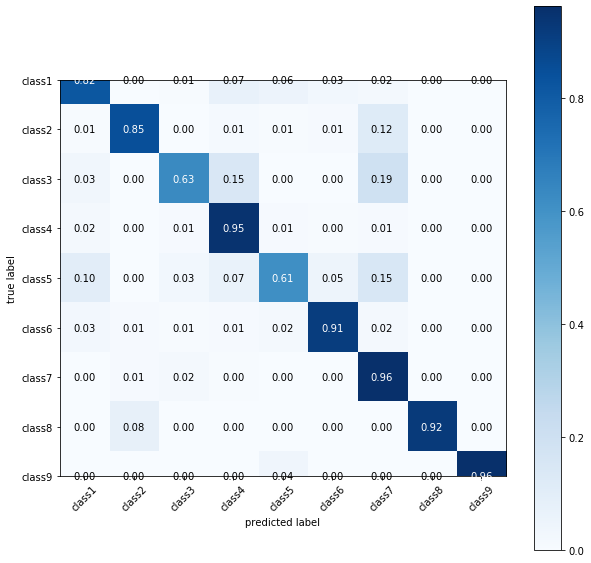

In [132]:
print('Confusion matrix (train set):')
cm=confusion_matrix(y_train[:y_train.shape[0]],y_pred)
#print('Confusion matrix (train set):\n\n',cm)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize=(10, 10),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=target_names,
                               )
plt.show()

In [133]:
# Evaluate best XGB-2 model multiclass_log_loss, on TEST SET
best_xgb_model_2_predict_probab_test=best_xgb_model_2.predict_proba(X_test_final_df.values)
best_xgb_model_2_multiclass_log_loss_test=log_loss(y_test_final,best_xgb_model_2_predict_probab_test,labels=[1,2,3,4,5,6,7,8,9])
print('Best XGB model-2 multiclass_log_loss, on TEST SET:',round(best_xgb_model_2_multiclass_log_loss_test,6))

Best XGB model-2 multiclass_log_loss, on TEST SET: 1.025881


In [134]:
# Evaluate predictions, ON TEST SET
y_pred=(np.argmax(best_xgb_model_2_predict_probab_test,axis=1))+1

print('Classification report (test set):\n')
print(classification_report(y_test_final, y_pred,target_names=target_names))

Classification report (test set):

              precision    recall  f1-score   support

      class1       0.59      0.58      0.59       170
      class2       0.63      0.46      0.53       136
      class3       0.53      0.37      0.43        27
      class4       0.66      0.70      0.68       206
      class5       0.44      0.36      0.39        73
      class6       0.79      0.56      0.66        82
      class7       0.69      0.89      0.78       286
      class8       0.00      0.00      0.00         6
      class9       0.67      0.36      0.47        11

    accuracy                           0.65       997
   macro avg       0.55      0.48      0.50       997
weighted avg       0.64      0.65      0.64       997



Confusion matrix (test set):


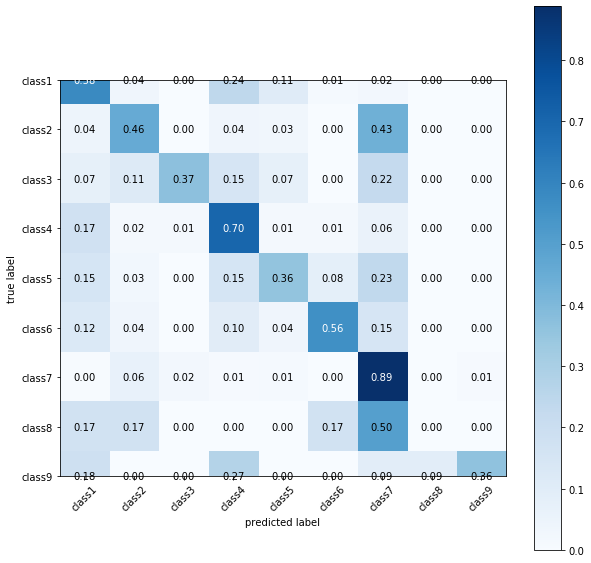

In [135]:
print('Confusion matrix (test set):')
cm=confusion_matrix(y_test_final,y_pred)
#print('Confusion matrix (test set):\n\n',cm)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize=(10, 10),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=target_names,
                               )
plt.show()

#### Comments: Classes 3, 5 show significantly lower recall rates than the other classes; all scores are lower than train set, but the drop-off is not as pronounced as in model-1, indicating that this model-2 (without use of oversampling to correct data imbalance) generalizes better to unseen data.

### Load competition data

In [136]:
# read in full test data
test_variants=pd.read_csv('stage2_test_variants.csv')
test_text=pd.read_csv('stage2_test_text.csv',sep='\|\|',engine='python',skiprows=1,names=['ID','Text'])

# merge both test dataframes
testing_full=test_variants.merge(test_text, on='ID', how='inner')

#remove leading and trailing spaces and lower-case 'Gene'
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.strip())
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.lower())

# clean text data on 'Variation'
testing_full['Variation'] = testing_full['Variation'].apply(text_preprocessor_tokenizer)
testing_full['Text'] = testing_full['Text'].apply(text_preprocessor_tokenizer)

### Evaluate competition test data

In [137]:
# create X_eval
X_eval_df=testing_full.copy()

# features to TF-IDF
cat_features_tfidf=['Text']

# TF-IDF
eval_Text=X_eval_df['Text']
eval_Text_tfidf=tfidf.transform(eval_Text)

# create dataframe of 'Text' (tfidf) feature only
eval_Text_tfidf_df=pd.DataFrame(eval_Text_tfidf.todense(),columns=tfidf.get_feature_names())
#concat with rest of the X_eval
X_eval_Text_tfidf_df=pd.concat([X_eval_df,eval_Text_tfidf_df],axis=1).drop(columns=['Text'])
# Drop (unenessary) ID column
X_eval_Text_tfidf_drop_ID_df=X_eval_Text_tfidf_df.drop(columns=['ID']).copy()

# one-hot encode 'Gene','Variation' - keeping all one-hot columns, since not using linear regression models (but rather just trees) 
eval_1hot_cols=onehotenc.transform(X_eval_Text_tfidf_drop_ID_df[cat_features].values.reshape(-1,len(cat_features)))
eval_1hot_cols_df=pd.DataFrame(eval_1hot_cols.astype(int))

# rename one-hot columns
eval_1hot_cols_df.columns=onehotenc.get_feature_names()

#concat with rest of the X_eval
X_eval_1hot_cols_Text_tfidf_drop_ID_df=pd.concat([eval_1hot_cols_df,X_eval_Text_tfidf_drop_ID_df],axis=1).drop(columns=['Gene','Variation'])

# standardize all non-ID columns - NOT NECESSARY for tree models
# X_eval_1hot_cols_Text_tfidf_drop_ID_scale=scaler.transform(X_eval_1hot_cols_Text_tfidf_drop_ID_df)

# create final eval data sets
X_eval_final_df=X_eval_1hot_cols_Text_tfidf_drop_ID_df.copy()

print("X_eval_final_df shape:", X_eval_final_df.shape)
X_eval_final_df

X_eval_final_df shape: (986, 3339)


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,year,years,yeast,âˆ,î²,î³,î¼g,î¼l,î¼m,ƒâ
0,0,0,0,0,0,0,0,0,0,0,...,0.038223,0.071634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.010741,0.000000,0.003644,0.226655,0.000000,0.025131,0.035551,0.011645,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.039130,0.017099,0.039828,0.000000,0.000000,0.156951,0.000000,0.042424,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.005404,0.009003,0.000000,0.027491,0.008905,0.000000,0.000000,0.000000,0.000000,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.010894,0.009074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0,0,0,0,0,0,0,0,0,0,...,0.003151,0.060362,0.000000,0.000000,0.041535,0.000000,0.000000,0.000000,0.000000,0.0
982,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.009687,0.014121,0.000000,0.004772,0.005906,0.051591,0.0
983,0,0,0,0,0,0,0,0,0,0,...,0.002920,0.043783,0.000000,0.037137,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
984,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.041683,0.105320,0.132876,0.000000,0.000000,0.000000,0.0


In [138]:
# Evaluate best XGB-2 model on competition test data
best_xgb_model_2_predict_probab_for_competition=best_xgb_model_2.predict_proba(X_eval_final_df.values)

In [139]:
# Create CSV file for competition entry
best_xgb_model_2_predict_probab_for_competition=pd.DataFrame(best_xgb_model_2_predict_probab_for_competition)
best_xgb_model_2_predict_probab_for_competition=pd.concat([X_eval_df[['ID']],best_xgb_model_2_predict_probab_for_competition],axis=1)
best_xgb_model_2_predict_probab_for_competition.columns=sample_submission.columns

### DataFrame for submission: Probabilistic prediction, into 9 classes, of genetic variations in test files (stage2_test_variants & stage2_test_text)

In [140]:
best_xgb_model_2_predict_probab_for_competition

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.368281,0.084057,0.075743,0.146198,0.068229,0.129645,0.114616,0.006338,0.006894
1,2,0.971229,0.001124,0.000534,0.014873,0.002784,0.001217,0.007843,0.000169,0.000228
2,3,0.115704,0.158849,0.005694,0.166069,0.023158,0.027335,0.484975,0.013009,0.005207
3,4,0.021403,0.399260,0.009089,0.257112,0.037500,0.047725,0.219270,0.003880,0.004762
4,5,0.015354,0.086830,0.002143,0.046243,0.011647,0.008819,0.826372,0.001079,0.001512
...,...,...,...,...,...,...,...,...,...,...
981,982,0.117736,0.047680,0.007474,0.747923,0.023232,0.022354,0.027672,0.003312,0.002618
982,983,0.136510,0.338152,0.012352,0.044744,0.010544,0.026286,0.418790,0.007716,0.004908
983,984,0.064506,0.576258,0.031311,0.161018,0.028157,0.036796,0.094598,0.003247,0.004110
984,985,0.261608,0.076172,0.008459,0.404027,0.022990,0.029899,0.185382,0.003373,0.008090


In [141]:
best_xgb_model_2_predict_probab_for_competition.to_csv('DC20191111b',index=False)

## Submission #2, by Daniel Cunza - Private Score: 2.93763, Public Score: 1.08982

## Conclusions:

#### * Even though the training set indicated a heavy imbalanced among the 9 class targets, a resampling approach (via over-sampling techniques) proved to be inefficient in this case, as observed by the model's significant overfitting of the training data. Thus resampling strategies are not recommended.

#### * Given the observed recall rates, classes 3 and 5 were observed as the most the significant culprits for the lower test-set classifications scores; and the errors for BOTH of these classes were mostly due to mis-classifications as class 7. Thus recommending precision/recall thresholds be adjusted for optimal recall among classes 3, 5, and 7.

#### * Final submitted files:
- XGBoost model: finalized_XBG_model_2.sav  
- CSV probability prediction: DC20191111b.csv

#### * TODO:  
1. Create pipelines for all data pre-processing, for better code portability.
2. Breakout single classifier into two (one for the categorical features, one of text feature), and then "merge" the probability tables.
3. Attempt another classification strategy aside from XGBoost'ed trees; specifically, Support Vector Machines (SVMs) would be a good candidate. 